In [2]:
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
import numpy as np
from termcolor import colored
import math
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from dataloader import get_ref_num_list, DataLoader
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_visible_devices(gpus[1], 'GPU')

In [3]:
img_rows = 128
img_cols = 128
channels = 1
n= 32
# 입력 이미지 차원
img_shape = (img_rows, img_cols, channels)

# 생성자 입력으로 사용될 잡음 벡터의 크기
z_dim = 1000

In [4]:
def _Conv2D(inp,filters=32,kernel_size=3,strides=1,padding="same",activation='relu'):
    x = Conv2D(filters=filters,kernel_size=(kernel_size,kernel_size)
               ,strides=strides,padding=padding)(inp)
    if activation =='relu':
        x = BatchNormalization(momentum=0.8)(x)
        x = Activation(activation)(x)
    elif activation == 'sigmoid':
        x = tf.keras.activations.sigmoid(x)
    return x

def build_generator():
    height,width = 41,41
    inp1 = layers.Input(shape=( height,width ,1))
    inp2 = layers.Input(shape=(1,))
    inp3 = layers.Input(shape=(1,))
    c1_layer = layers.RepeatVector(height * width)(inp2)
    c1_layer = layers.Reshape([height, width, 1])(c1_layer)
    c2_layer = layers.RepeatVector(height * width)(inp3)
    c2_layer = layers.Reshape([height, width, 1])(c2_layer)
    
    inp = layers.Concatenate(axis=-1)([inp1, c1_layer, c2_layer])
    x = _Conv2D(inp, filters=32,kernel_size=2 ,padding='valid')
    x = _Conv2D(x, filters=32)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = _Conv2D(x,filters=64)
    x = _Conv2D(x,filters=64)
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    x = _Conv2D(x,filters=128)
    x = _Conv2D(x,filters=128)
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    x = _Conv2D(x,filters=256)
    x = _Conv2D(x,filters=256)
    x = UpSampling2D()(x)

    x = _Conv2D(x,filters=128)
    x = _Conv2D(x,filters=128)
    x = UpSampling2D()(x)
    
    x = _Conv2D(x,filters=64)
    x = _Conv2D(x,filters=64)
    x = UpSampling2D()(x)
    
    x = _Conv2D(x,filters=32)
    x = _Conv2D(x,filters=2)
    out = _Conv2D(x,filters=1,activation='sigmoid')
    
    return Model(inputs=[inp1,inp2,inp3],outputs=out,name='generator')

In [5]:
def build_generator():

    inp = Input(shape=(z_dim,))

    # 완전 연결층을 통해 입력을 7x7x256 크기 텐서로 변환
    x = Dense(256 * n * n)(inp)
    x = Reshape((n, n, 256))(x)
    # 7x7x256에서 14x14x128 텐서로 바꾸는 전치 합성곱 층
    x = Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)

    # 배치 정규화
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)

    # 14x14x128에서 14x14x64 텐서로 바꾸는 전치 합성곱 층
    x = Conv2DTranspose(64, kernel_size=3, strides=1, padding='same')(x)

    # 배치 정규화
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)

    # 14x14x64에서 28x28x1 텐서로 바꾸는 전치 합성곱 층
    x = Conv2DTranspose(1, kernel_size=3, strides=2, padding='same')(x)
    out = Activation('tanh')(x)

    return Model(inp,out)

In [6]:

def build_discriminator():

    inp = Input(shape=img_shape)

    # 28x28x1에서 14x14x32 텐서로 바꾸는 합성곱 층
    x = Conv2D(32,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same')(inp)

    # LeakyReLU 활성화 함수
    x = LeakyReLU(alpha=0.01)(x)

    # 14x14x32에서 7x7x64 텐서로 바꾸는 합성곱 층
    x = Conv2D(64,
               kernel_size=3,
               strides=2,
               padding='same')(x)

    # LeakyReLU 활성화 함수
    x = LeakyReLU(alpha=0.01)(x)

    # 7x7x64에서 3x3x128 텐서로 바꾸는 합성곱 층
    x = Conv2D(128,
               kernel_size=3,
               strides=2,
               padding='same')(x)

    # LeakyReLU 활성화 함수
    x = LeakyReLU(alpha=0.01)(x)
    
    # sigmoid 활성화 함수를 사용한 출력층
    x = Flatten()(x)
    out = Dense(1, activation='sigmoid')(x)

    return Model(inp,out)

In [14]:
def build_gan(generator,discriminator):
    inp = Input(shape=(z_dim,))
    gan = discriminator(generator(inp))
    return Model(inp,gan)

In [8]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # 랜덤한 잡음 샘플링
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # 랜덤한 잡음에서 이미지 생성하기
    gen_imgs = generator.predict(z)

    # 이미지 픽셀 값을 [0, 1] 사이로 스케일 조정
    gen_imgs = 0.5 * gen_imgs + 0.5

    # 이미지 그리드 설정
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # 이미지 그리드 출력
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

In [10]:
iterations = 20000
batch_size = 64
z_dim = 1000
sample_interval = 200

In [11]:
# 데이터 경로 불러오기 
ref_path = '../data/reference_image/'
lbl_path = '../data/binary_label_11/'
# 학습 데이터 인덱스 불러오기
train_ref_num = np.load('../TopOpNet/train_ref_num.npy')
valid_ref_num = np.load('../TopOpNet/valid_ref_num.npy')
test_ref_num = np.load('../TopOpNet/test_ref_num.npy')
tdl = DataLoader(ref_path, lbl_path, n_batch=batch_size, ref_num_list=train_ref_num, pdf_npy=None, from_mem=True)
vdl = DataLoader(ref_path, lbl_path, n_batch=batch_size, ref_num_list=valid_ref_num, pdf_npy=None, from_mem=True)

ref_imgs, c1, c2, opt_imgs = tdl.get_next()

In [15]:
gen_learning_rate = 0.0005
dis_learning_rate = 0.0003
beta = 0.5
    
# 판별자 모델을 만들고 컴파일하기
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(lr=dis_learning_rate,beta_1=beta),
                      metrics=['accuracy'])

# 생성자 모델 만들기
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=gen_learning_rate,beta_1=beta))
# 생성자를 훈련하는 동안 판별자의 파라미터를 유지
discriminator.trainable = False

# 생성자를 훈련하기 위해 동결된 판별자로 GAN 모델을 만들고 컴파일
gan = build_gan(generator,discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=gen_learning_rate,beta_1=beta))

  0%|          | 0/20000 [00:00<?, ?it/s]

iteration: 0 d_loss: 0.7085 d_acc: 0.0 % g_loss: 0.6287


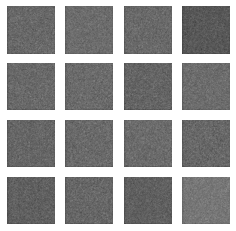

  1%|          | 200/20000 [01:05<1:51:53,  2.95it/s]

iteration: 200 d_loss: 0.0 d_acc: 1.0 % g_loss: 0.0


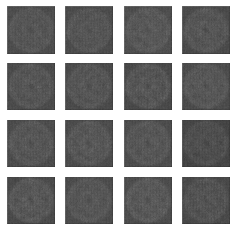

  2%|▏         | 400/20000 [02:09<1:39:36,  3.28it/s]

iteration: 400 d_loss: 0.0 d_acc: 1.0 % g_loss: 0.0


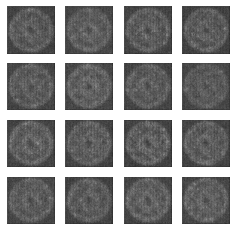

  3%|▎         | 600/20000 [03:16<1:50:40,  2.92it/s]

iteration: 600 d_loss: 0.0 d_acc: 1.0 % g_loss: 0.0001


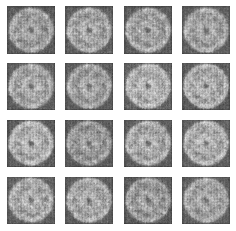

  4%|▍         | 800/20000 [04:22<1:48:20,  2.95it/s]

iteration: 800 d_loss: 0.0022 d_acc: 1.0 % g_loss: 0.0354


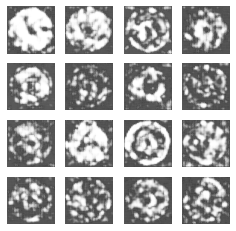

  5%|▌         | 1000/20000 [05:26<1:33:00,  3.40it/s]

iteration: 1000 d_loss: 0.0004 d_acc: 1.0 % g_loss: 0.0056


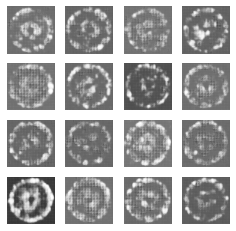

  6%|▌         | 1200/20000 [06:33<1:46:11,  2.95it/s]

iteration: 1200 d_loss: 0.3861 d_acc: 0.8672 % g_loss: 0.181


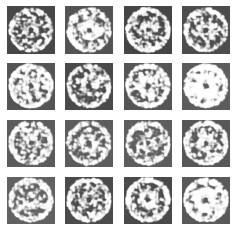

  7%|▋         | 1400/20000 [07:38<1:30:31,  3.42it/s]

iteration: 1400 d_loss: 0.1197 d_acc: 0.9922 % g_loss: 0.6062


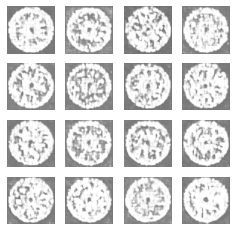

  8%|▊         | 1600/20000 [08:44<1:46:39,  2.88it/s]

iteration: 1600 d_loss: 0.2685 d_acc: 0.9062 % g_loss: 0.1202


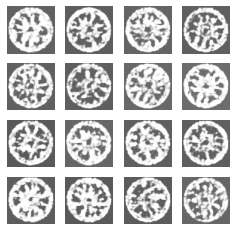

  9%|▉         | 1800/20000 [09:50<1:34:56,  3.20it/s]

iteration: 1800 d_loss: 0.4428 d_acc: 0.9062 % g_loss: 0.6126


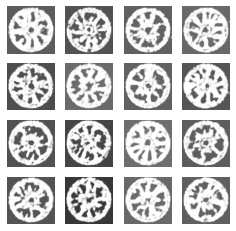

 10%|█         | 2000/20000 [10:55<1:35:49,  3.13it/s]

iteration: 2000 d_loss: 0.4177 d_acc: 0.9219 % g_loss: 1.0952


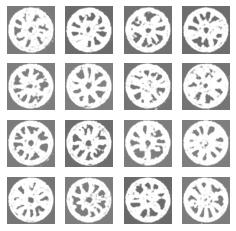

 11%|█         | 2200/20000 [12:01<1:31:54,  3.23it/s]

iteration: 2200 d_loss: 0.6814 d_acc: 0.5469 % g_loss: 1.2564


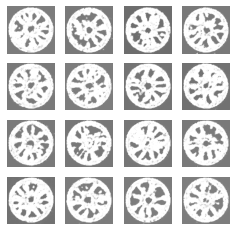

 12%|█▏        | 2400/20000 [13:06<1:36:18,  3.05it/s]

iteration: 2400 d_loss: 0.5969 d_acc: 0.75 % g_loss: 1.1469


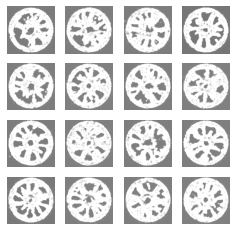

 13%|█▎        | 2600/20000 [14:12<1:34:28,  3.07it/s]

iteration: 2600 d_loss: 0.6362 d_acc: 0.6406 % g_loss: 1.1138


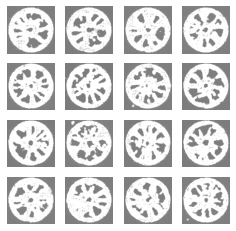

 14%|█▍        | 2800/20000 [15:18<1:35:14,  3.01it/s]

iteration: 2800 d_loss: 0.5553 d_acc: 0.7969 % g_loss: 1.3398


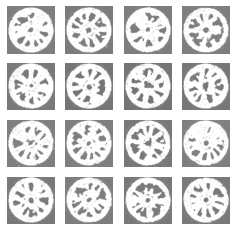

 15%|█▌        | 3000/20000 [16:23<1:39:56,  2.84it/s]

iteration: 3000 d_loss: 0.5219 d_acc: 0.8359 % g_loss: 1.4674


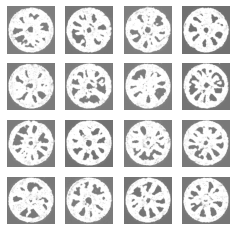

 16%|█▌        | 3200/20000 [17:27<1:30:34,  3.09it/s]

iteration: 3200 d_loss: 0.4533 d_acc: 0.875 % g_loss: 1.5686


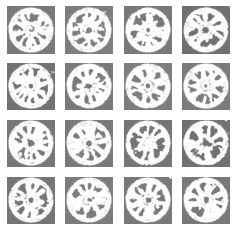

 17%|█▋        | 3400/20000 [18:33<1:28:24,  3.13it/s]

iteration: 3400 d_loss: 0.4118 d_acc: 0.9375 % g_loss: 1.6667


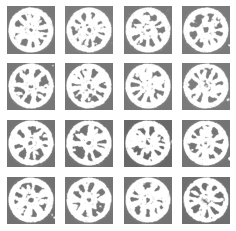

 18%|█▊        | 3540/20000 [19:19<1:25:17,  3.22it/s]

In [ ]:
losses = []
accuracies = []
iteration_checkpoints = []
iterations = 20000
batch_size = 64
z_dim = 1000
sample_interval = 200

real = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for iteration in tqdm(range(iterations)):

    # 진짜 이미지에서 랜덤 배치 가져오기
    ref_imgs, _,_,_ = tdl.get_next()
    ref_imgs = ref_imgs.reshape(batch_size,128,128,1)
    # 가짜 이미지 배치 생성
    z = np.random.normal(0, 1, (batch_size, z_dim))
    gen_imgs = generator.predict(z)

    # 판별자 훈련
    d_loss_real = discriminator.train_on_batch(ref_imgs, real)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

    # 가짜 이미지 배치 생성
    z = np.random.normal(0, 1, (batch_size, z_dim))
    gen_imgs = generator.predict(z)

    # 생성자 훈련
    g_loss = gan.train_on_batch(z, real)

    if iteration % sample_interval == 0:

        print('iteration:',colored(iteration,'blue')
              ,'d_loss:',colored(np.round(d_loss,4),'red'),'d_acc:',colored(np.round(accuracy,4),'red'),'%'
              ,'g_loss:',colored(np.round(g_loss,4),'red')) 

        # 생성된 이미지 샘플 출력
        sample_images(generator)